<a href="https://colab.research.google.com/github/mandelatrey/ML/blob/main/Generating_CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
from torchvision import transforms
import torchvision.datasets 

#Defining the dataset

In [ ]:
image_path = './sample_data/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),

])

image_dataset = torchvision.datasets.MNIST(
    root = image_path, train=True, transform=transform, download=True
)

example, label = next(iter(image_dataset))
print(f'Min: {example.min()} max: {example.max()}')
print(example.shape)

Min: -1.0 max: 1.0
torch.Size([1, 28, 28])


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)

In [ ]:
#Making the helper functions

#Making the helper functions

In [ ]:
from torch.nn.modules.activation import LeakyReLU

def make_generator_network(input_size=20, 
                           num_hidden_layers=1, 
                           num_hidden_units=100,
                           num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g {i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module(f'tanh_g', nn.Tanh())
    return model

def make_discriminator_network(input_size, 
                           num_hidden_layers=1, 
                           num_hidden_units=100,
                           num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d: {i}', nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f'relu_d: {i}', nn.LeakyReLU())
        model.add_module(f'dropout: {i}', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_gd{num_hidden_units}', nn.Linear(input_size, num_output_units))
    model.add_module(f'sigmoid', nn.Sigmoid())
    return model

Creating the generator

In [ ]:
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)
)

print(gen_model)

Sequential(
  (fc_g 0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


Creating the decoder/discriminator

In [ ]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size), 
    num_hidden_layers = disc_hidden_layers, 
    num_hidden_units = disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d: 0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d: 0): LeakyReLU(negative_slope=0.01)
  (dropout: 0): Dropout(p=0.5, inplace=False)
  (fc_gd100): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Creating a function to create fake noise


In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    elif mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    return input_z

Creating fake noise (z_)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(image_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'uniform' #can either be uniform or normal --check create _noise()--
input_z = create_noise(batch_size, z_size, mode_z) 

print('input-z --shape: ', input_z.shape) #the fake image
print('input-real --shape: ', input_real.shape) #the real image

input-z --shape:  torch.Size([32, 20])
input-real --shape:  torch.Size([32, 784])


In [ ]:
g_output = gen_model(input_z)
print('Out of Generator Image--shape: ', g_output.shape)

Out of Generator Image--shape:  torch.Size([32, 784])


In [ ]:
d_prob_real = disc_model(input_real)
d_prob_fake = disc_model(g_output)
print(f'Decoder (real image) --shape:', d_prob_real.shape)
print(f'Decoder (fake image) --shape:', d_prob_fake.shape)

Decoder (real image) --shape: torch.Size([32, 1])
Decoder (fake image) --shape: torch.Size([32, 1])


#Training the model

In [ ]:
loss_fn = nn.BCELoss() #loss function
g_labels_real = torch.ones_like(d_prob_real)
g_loss = loss_fn(d_prob_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

Generator Loss: 0.6983


In [ ]:
d_labels_real = torch.ones_like(d_prob_real)
d_labels_fake = torch.zeros_like(d_prob_fake)
d_loss_real = loss_fn(d_prob_real, d_labels_real)
d_loss_fake = loss_fn(d_prob_fake, d_labels_fake)
print(f'Decoder Loss for real data {d_loss_real:.4f}',
      f'\nDecoder loss for fake data {d_loss_fake:.4f}')

Decoder Loss for real data 0.7479 
Decoder loss for fake data 0.6885


In [ ]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
device = 'cpu'
mnist_ds = DataLoader(image_dataset, batch_size=batch_size, shuffle=True,
                      drop_last=True)

gen_model = make_generator_network(
    input_size = z_size, 
    num_hidden_layers = gen_hidden_layers, 
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size = np.prod(image_size), 
    num_hidden_layers = disc_hidden_layers, 
    num_hidden_units = disc_hidden_size).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

#writing helper functions ie train functions for decoder and generator

We train the decoder first

In [ ]:
def d_train(x):
    disc_model.zero_grad()

    #training the disc with a real batch of data
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_probas_real = disc_model(x)
    d_loss_real = loss_fn(d_probas_real, d_labels_real)

    #training the disc on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_probas_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_probas_fake, d_labels_fake)

    #gradient backdrop and optimizing the discriminator alone
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item(), d_probas_real.detach(), d_probas_fake.detach()


def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)
    g_output = gen_model(input_z)
    d_probs_fake = disc_model(g_output)
    g_loss_ = loss_fn(d_probs_fake, g_labels_real)
    g_loss_.backward()
    g_optimizer.step()
    return g_loss_.data.item()

Do the same for the generator

In [ ]:
# def g_train(x):
#     gen_model.zero_grad()
#     batch_size = x.size(0)
#     input_z = create_noise(batch_size, z_size, mode_z).to(device)
#     g_labels_real = torch.ones(batch_size, 1, device=device)
#     g_output = gen_model(input_z)
#     d_probs_fake = disc_model(g_output)
#     g_loss_ = loss_fn(d_probs_fake, g_labels_real)
#     g_loss.backward()
#     g_optimizer.step()
#     return g_loss.data.item()

Creating a function to create sample images

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

#putting it all together and training the model

In [ ]:
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []

    for i, (x, _) in enumerate(mnist_ds):
        d_loss, d_probas_real, d_probas_fake = d_train(x)
        d_losses.append(d_loss)
        g_loss_ = g_train(x)
        g_losses.append(g_loss_)
        d_vals_real.append(d_probas_real.mean().cpu())
        d_vals_fake.append(d_probas_fake.mean().cpu())
    
    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(f'Epoch: {epoch:03d} | Avg Loss ----',
          f'Gen/Dec {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}',
          f'[D-Real: {all_d_real[-1]:.4f}]',
          f'[D-Fake: {all_d_fake[-1]:.4f}]'
          )

    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())
    
    

Epoch: 001 | Avg Loss ---- Gen/Dec 2.2913/0.3940 [D-Real: 0.9485] [D-Fake: 0.2703]
Epoch: 002 | Avg Loss ---- Gen/Dec 1.1610/0.8575 [D-Real: 0.7247] [D-Fake: 0.3493]
Epoch: 003 | Avg Loss ---- Gen/Dec 1.1876/1.0718 [D-Real: 0.6314] [D-Fake: 0.3697]
Epoch: 004 | Avg Loss ---- Gen/Dec 1.0769/1.1542 [D-Real: 0.6013] [D-Fake: 0.3887]
Epoch: 005 | Avg Loss ---- Gen/Dec 1.0483/1.1691 [D-Real: 0.5953] [D-Fake: 0.3947]
Epoch: 006 | Avg Loss ---- Gen/Dec 1.0257/1.2107 [D-Real: 0.5788] [D-Fake: 0.4086]
Epoch: 007 | Avg Loss ---- Gen/Dec 0.9455/1.2325 [D-Real: 0.5688] [D-Fake: 0.4214]
Epoch: 008 | Avg Loss ---- Gen/Dec 0.9331/1.2579 [D-Real: 0.5586] [D-Fake: 0.4281]
Epoch: 009 | Avg Loss ---- Gen/Dec 1.0068/1.2028 [D-Real: 0.5806] [D-Fake: 0.4106]
Epoch: 010 | Avg Loss ---- Gen/Dec 0.9453/1.2449 [D-Real: 0.5644] [D-Fake: 0.4261]
Epoch: 011 | Avg Loss ---- Gen/Dec 0.9122/1.2483 [D-Real: 0.5614] [D-Fake: 0.4302]
Epoch: 012 | Avg Loss ---- Gen/Dec 1.0611/1.1855 [D-Real: 0.5903] [D-Fake: 0.4028]
Epoc

Visualising training stats


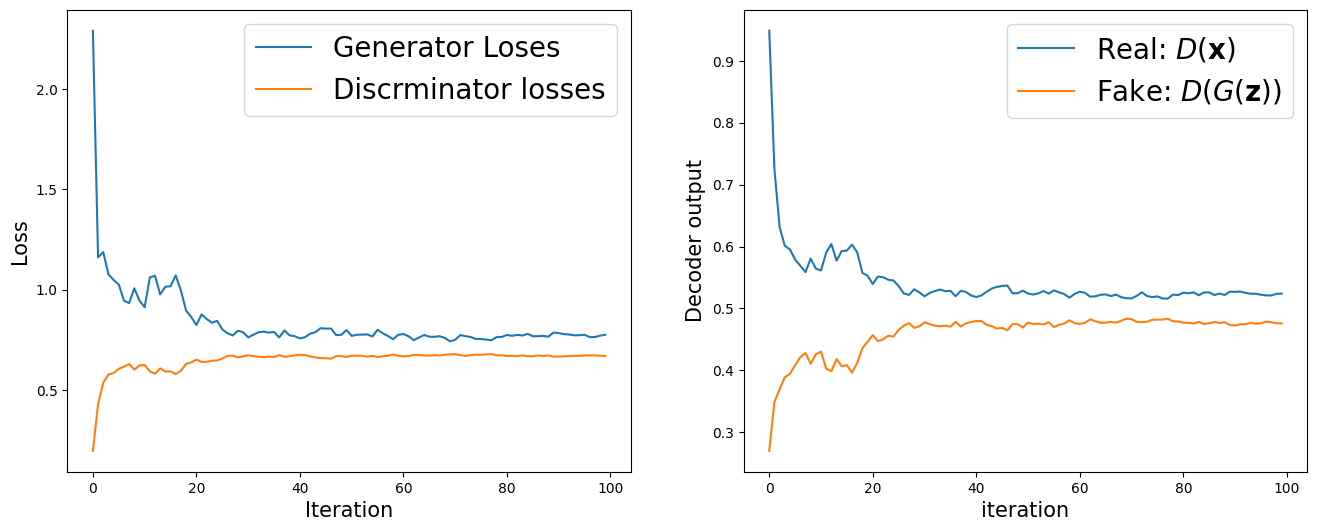

In [ ]:
import itertools 
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator Loses')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discrminator losses')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel("iteration", size=15)
ax.set_ylabel('Decoder output', size=15)
plt.show()

Visualising the outputs at different itterations

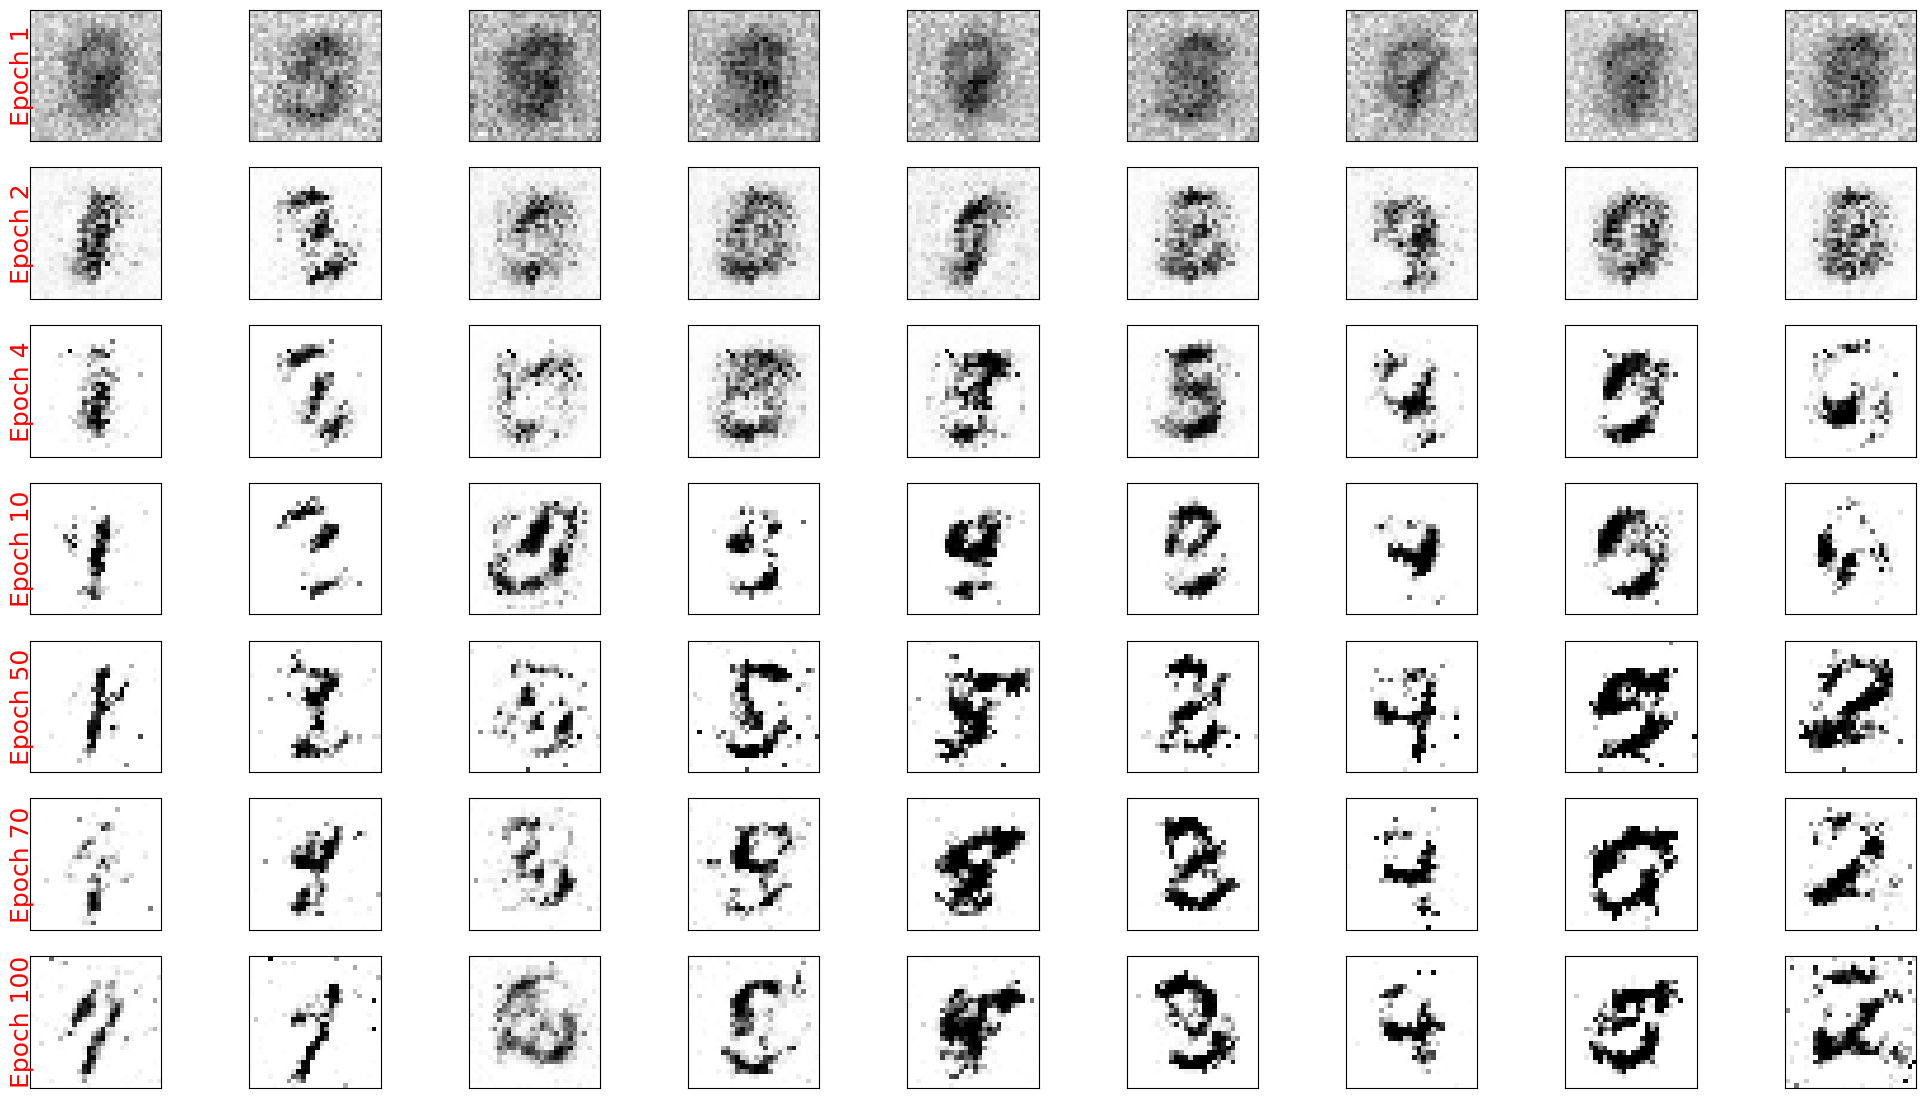

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 70, 100]
fig = plt.figure(figsize=(25, 14))
for i,e in enumerate(selected_epochs):
    for j in range(9):
        ax = fig.add_subplot(7, 9, i*9+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes
            )

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')



plt.show()

We'd want to have a better model, so lets try improving these

In [ ]:
from inspect import isgeneratorfunction
def wsan_generator_network(input_size_wsan, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size_wsan, n_filters*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )
    return model

class WsanDiscriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model_wsan = wsan_generator_network(z_size, n_filters).to(device)
disc_model_wsan = WsanDiscriminator(n_filters).to(device)
print(gen_model_wsan)
print(disc_model_wsan)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
WsanDiscriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=

In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model_wsan.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model_wsan.parameters(), 0.0002)

In [ ]:
def create_noize_wsan(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [ ]:
def d_train(x):
    disc_model.zero_grad()

    #training the disc with a real batch of data
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_probas_real = disc_model(x)
    d_loss_real = loss_fn(d_probas_real, d_labels_real)

    #training the disc on a fake batch
    input_z_wsan = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model_wsan(input_z_wsan)
    d_probas_fake = disc_model_wsan(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_probas_fake, d_labels_fake)

    #gradient backdrop and optimizing the discriminator alone
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item(), d_probas_real.detach(), d_probas_fake.detach()


In [ ]:
input_z_wsan = create_noise(batch_size, z_size, mode_z).to(device)
input_z_wsan.shape

torch.Size([64, 100])

In [ ]:
fixed_z_wsan = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples_wsan = []
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model_wsan.train()
    for i, (x, _) in enumerate(mnist_ds):
        d_loss, d_probas_real, d_probas_fake = d_train(x)
        d_losses.append(d_loss)
        g_loss_ = g_train(x)
        g_losses.append(g_loss_)

    print(f'Epoch {epoch:03d} | Avg Losses >>>',
          f' Generator Vs Decoder: {torch.FloatTensor(g_losses).mean():.4f}',
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    
    gen_model_wsan.eval()
    epoch_samples.append(
        create_samples(gen_model_wsan, fixed_z_wsan).detach().cpu().numpy()
    )

